In [125]:
%load_ext autoreload
%autoreload 2

In [120]:
import sys
sys.path.append('../')

In [109]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
import pandas as pd
import pydot

In [128]:
from visualization.color_graphs import Color

In [3]:
blocks = np.array([16,17,9,15,13,11,11,16,9,10])
val_accuracies = np.array([68.16,67.99,67.51,66.79,66.83,67.99,67.59,67.19,67.41,66.67])

In [13]:
len(blocks)

10

In [14]:
len(val_accuracies)

10

<IPython.core.display.Javascript object>


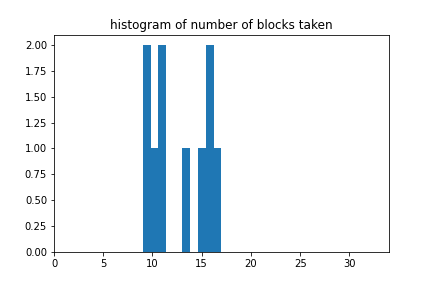

In [77]:
fig, ax = plt.subplots(1,1)
ax.set(title='histogram of number of blocks taken')
ax.set(xlim=[0,34])
ax.hist(blocks)
plt.show()

In [78]:
def acc_vs_blocks_taken_scatter(blocks_taken, acc, title='Val acc vs. number blocks taken'):
    fig, ax = plt.subplots(1,1)
    ax.set(title=title, yLabel='val. acc.', xLabel='number blocks taken')
    ax.scatter(blocks_taken, acc)
    m, c = np.linalg.lstsq(np.vstack((blocks, np.ones(len(blocks_taken)))).T, acc)[0]
    xlim = ax.get_xlim()
    xx = np.linspace(*xlim).T
    ax.plot(xx, w[0]*xx + w[1], '-k')
    plt.show()

<IPython.core.display.Javascript object>


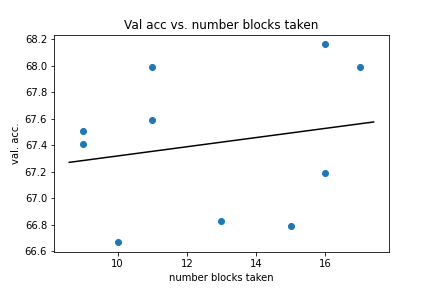

/home/tobias/virtualenv_environments/BmxNet/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


In [79]:
acc_vs_blocks_taken_scatter(blocks, val_accuracies)

In [54]:
trainings = ['meliusnet22_enas_2020_7_25_13_9', 'meliusnet22_enas_2020_7_25_18_59', 'meliusnet22_enas_2020_7_26_0_48', 'meliusnet22_enas_2020_7_26_6_38', 'meliusnet22_enas_2020_7_26_12_28', 'meliusnet22_enas_2020_7_26_18_17', 'meliusnet22_enas_2020_7_27_0_6', 'meliusnet22_enas_2020_7_27_5_56', 'meliusnet22_enas_2020_7_27_11_46', 'meliusnet22_enas_2020_7_27_17_35']
training_dir = '../trainings/'

In [55]:
block_summaries = []
for training_name in trainings:
    block_summaries.append(pd.read_csv(training_dir+training_name+ '/logs/architectures/block_summary.csv'))

In [56]:
used_dense_blocks = [x['used_dense'][99] for x in block_summaries]
used_improvement_blocks = [x['used_improvement'][99] for x in block_summaries]
used_blocks= np.array(used_dense_blocks) + np.array(used_improvement_blocks)

<IPython.core.display.Javascript object>


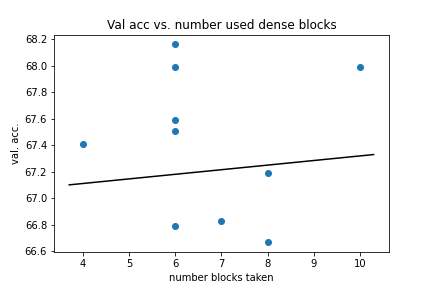

/home/tobias/virtualenv_environments/BmxNet/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


In [80]:
acc_vs_blocks_taken_scatter(used_dense_blocks, val_accuracies, "Val acc vs. number used dense blocks")

<IPython.core.display.Javascript object>


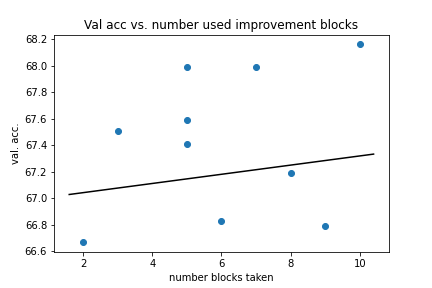

/home/tobias/virtualenv_environments/BmxNet/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


In [81]:
acc_vs_blocks_taken_scatter(used_improvement_blocks, val_accuracies, "Val acc vs. number used improvement blocks")

<IPython.core.display.Javascript object>


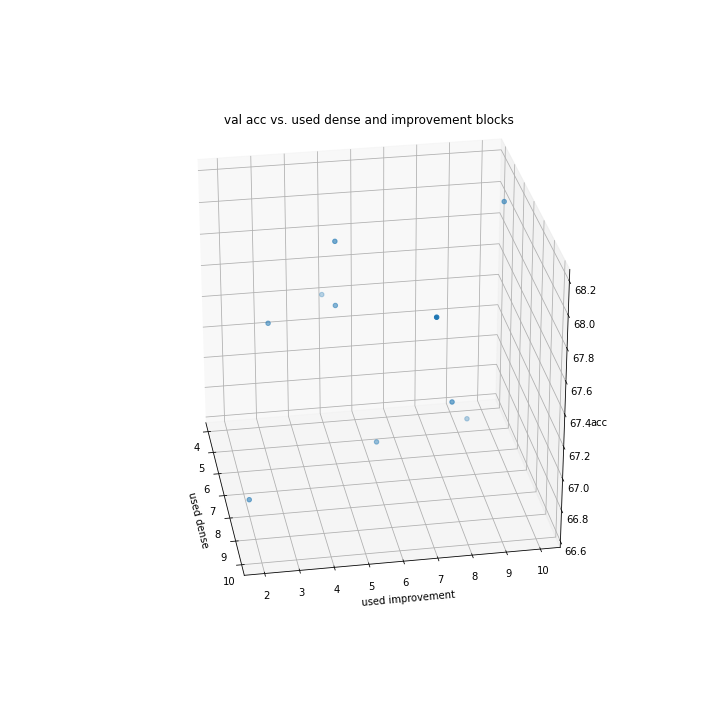

In [87]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.set(title='val acc vs. used dense and improvement blocks')
ax.set_xlabel('used dense')
ax.set_ylabel('used improvement')
ax.set_zlabel('acc')
ax.scatter(used_dense_blocks, used_improvement_blocks, val_accuracies)
plt.show()

In [103]:
def meliusnet_config_array_from_dot_file(file_path):
    block_types = [] # 1 is improvement block, 2 is dense block
    block_skipped = []
    with open(file_path) as file:
        for line in file:
            block_type = None
            skipped = None
            if 'ImprovementBlockEnas' in line:
                block_type = 1
            if 'DenseBlockEnas' in line:
                block_type = 2
            if block_type:
                if 'RTrue' in line:
                    skipped = True
                elif 'RFalse' in line:
                    skipped = False
                else:
                    raise ValueError('parsing error')
                block_types.append(block_type)
                block_skipped.append(skipped)
    return np.array([[x,y] for x,y in zip(block_types, block_skipped)])

In [106]:
last_config = meliusnet_config_array_from_dot_file(training_dir+trainings[0]+ '/logs/architectures/epoch_99.dot')[:,0]
counts = np.zeros(len(last_config))
for training_name in trainings:
    config = meliusnet_config_array_from_dot_file(training_dir+training_name+ '/logs/architectures/epoch_99.dot')
    if not np.all(config[:,0]==last_config):
        raise Error('Connot compare different configs')
    counts += config[:,1]

In [108]:
counts/10

array([0.5, 0.8, 0.9, 0.8, 0.7, 0.5, 0.9, 0.9, 0.7, 0.7, 0.6, 0.7, 0.5,
       0.8, 0.8, 0.7, 0.4, 0.7, 0.5, 0.5, 0.5, 0.6, 0.7, 0.4, 0.6, 0.6,
       0.3, 0.8, 0.4, 0.4, 0.7, 0.5, 0.6, 0.6])

In [142]:
dot = pydot.graph_from_dot_file(training_dir+trainings[0]+ '/logs/architectures/epoch_99.dot')[0]
index = 0
probs = counts / 10
for node in dot.get_node_list():
    attributes = node.get_attributes()
    new_color = None
    if 'label' not in attributes:
        continue
    if 'ImprovementBlockEnas' in attributes['label'] or 'DenseBlockEnas' in attributes['label']:
        prob = probs[index]
        new_color = Color.mix(Color(r=255,g=0,b=0), Color(r=0,g=255,b=0), mix_fac=prob)
        node.set_color(new_color.as_hex())
        node.set_label(attributes['label'] + ' skip_probability:' + str(prob))
        index+=1
dot.write_png('10_trainings_average_meliusnet22_enas.png')